# Data Clustering

steps in this notebook

1. pull in the data

2. try a simple k means clustering

3. try an autoencoder with k means clustering

4. try and auto encoder with t-sne

In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
img_md_subset = pd.read_csv('../../../Data/ifcb_ecotaxa_subset.csv')
img_md_subset = img_md_subset.drop('Unnamed: 0', 1)

pull out a random subset for speed

In [3]:
import glob, os

file_dir = '../../../Data/all_imagery/'

os.chdir(file_dir)
fn_list = []
for file in glob.glob("*.png"):
    fn_list.append(file)


In [4]:
fn_edit = [x[:-4] for x in fn_list]

In [5]:
img_subset_with_data = img_md_subset[img_md_subset['object_id'].isin(fn_edit)]
len(img_subset_with_data)

814838

In [197]:
class_id_list = [[x, i] for i, x in enumerate(list(img_subset_with_data.groupby('object_annotation_category')['object_id'].nunique().index))]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

{0: 'Amphiprora',
 1: 'Ceratium',
 2: 'Chaetoceros<Mediophyceae',
 3: 'Ciliophora',
 4: 'Cocconeis',
 5: 'Corethron',
 6: 'Cryptophyta',
 7: 'Cylindrotheca',
 8: 'Dictyochales',
 9: 'Dinophyceae',
 10: 'Eucampia',
 11: 'Fragilariopsis',
 12: 'Guinardia',
 13: 'Gymnodinium',
 14: 'Gyrodinium',
 15: 'Katodinium',
 16: 'Licmophora',
 17: 'Membraneis',
 18: 'Navicula',
 19: 'Nitzschia stellata',
 20: 'Odontella sp.',
 21: 'Phaeocystis',
 22: 'Polykrikos<Polykrikaceae',
 23: 'Proboscia sp.',
 24: 'Pseudo-Nitzschia chain',
 25: 'Pterosperma',
 26: 'Pyramimonas',
 27: 'Rhizosolenia',
 28: 'Thalassiosira',
 29: 'Tintinnida',
 30: 'Torodinium',
 31: 'Unknowns',
 32: 'Warnowia',
 33: 'badfocus<artefact',
 34: 'bead',
 35: 'bubble',
 36: 'centric',
 37: 'centric 1 temp',
 38: 'centric 10 temp',
 39: 'centric 2 temp',
 40: 'centric 3 temp',
 41: 'centric 4 temp',
 42: 'centric 5 temp',
 43: 'centric 6 temp',
 44: 'centric 7 temp',
 45: 'centric 9 temp',
 46: 'chain<centric',
 47: 'chain<pennate',


In [194]:
df_val = img_subset_with_data[img_subset_with_data.object_annotation_status == 'validated']
df_val.head()

object_id object_annotation_status  \
3592  D20171114T191311_IFCB116_02541                validated   
3593  D20171114T191311_IFCB116_01183                validated   
3594  D20171114T191311_IFCB116_00659                validated   
3595  D20171114T191311_IFCB116_01034                validated   
3596  D20171114T191311_IFCB116_02467                validated   

     object_annotation_category  \
3592                Pyramimonas   
3593                Pyramimonas   
3594               Dictyochales   
3595                  Corethron   
3596                       t011   

                            object_annotation_hierarchy sample_flag  \
3592  living>Eukaryota>Archaeplastida>Viridiplantae>...  incomplete   
3593  living>Eukaryota>Archaeplastida>Viridiplantae>...  incomplete   
3594  living>Eukaryota>Harosa>Stramenopiles>Ochrophy...  incomplete   
3595  living>Eukaryota>Harosa>Stramenopiles>Ochrophy...  incomplete   
3596                                     temporary>t011  incomplete   

      object_lat  object_lon  object_date  object_time  
3592    -64.7795    -64.0417     20171114       191311  
3593    -64.7795    -64.0417     20171114       191311  
3594    -64.7795    -64.0417     20171114       191311  
3595    -64.7795    -64.0417     20171114       191311  
3596    -64.7795    -64.0417     20171114       191311

In [16]:
df_sample = img_subset_with_data.sample(10000)
len(df_sample)

10000

These are major outliers so worth taking them out sometimes

In [17]:
df_sample = df_sample[df_sample.object_annotation_category != 'badfocus<artefact']
len(df_sample)

9050

Create class name dicts

Pull in all the data to memory

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

images = []
labels = []

for index, row in df_sample.iterrows():
    
    # TODO need to think about optimal size and that size actually corresponds to class
    # maybe add blackspace instead of interpolating because it is changing the morphology

    img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
    images.append(image.img_to_array(img))
    try:
        labels.append(class_id_dict[row['object_annotation_category']])
    except KeyError: # this is to catch a couple nans
        print('found nan')
        labels.append(class_id_dict['part<other'])
images = np.array(images)
labels = np.array(labels)

images.shape, labels.shape

found nan
found nan
found nan


((9050, 150, 150, 1), (9050,))

train it on this subset

K-Means

In [47]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

First flatten the data for scikit learn

In [48]:
x_minst = x_train.reshape((x_train.shape[0], -1))

x = images.reshape((images.shape[0], -1))
x.shape, x_minst.shape

((9050, 22500), (60000, 784))

visualize in PCA

In [49]:
X_reduced_minst = PCA(n_components=3).fit_transform(x_minst)
X_reduced_minst.shape

(60000, 3)

In [186]:
X_reduced = PCA(n_components=3).fit_transform(x)
X_reduced.shape

(9031, 3)

In [50]:
df_minst = pd.DataFrame(np.array([X_reduced_minst[:, 0], X_reduced_minst[:, 1], X_reduced_minst[:, 2], 
                                  y_train]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df_minst.head()

pc1         pc2         pc3  label
0   123.934548 -312.678743  -24.494610    5.0
1  1011.720188 -294.854550  596.334097    0.0
2   -51.850093  392.171720 -188.507306    4.0
3  -799.126848 -607.214653  273.658732    1.0
4  -382.754921  730.558262   16.342057    9.0

In [146]:
df = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], [id_class_dict[x] for x in labels]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df.head()

pc1         pc2         pc3           label
0   3603.6184  -1230.0912   989.39465  multiple<other
1   1538.9626   879.28156    956.7162  pennate 2 temp
2  -1005.1878    787.1251  -1506.3668            t002
3   1335.9458  -1157.7488   -445.8048  pennate 1 temp
4    3865.033   -561.2984   -706.2714     Pyramimonas

In [52]:
import plotly.express as px
fig = px.scatter_3d(df_minst.sample(1000), x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

In [147]:
import plotly.express as px
fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

In [148]:
validated_samples = X_reduced[df_sample.object_annotation_status == 'validated']
val_labels = labels[df_sample.object_annotation_status == 'validated']
len(validated_samples)

248

In [149]:
df = pd.DataFrame(np.array([validated_samples[:, 0], validated_samples[:, 1], validated_samples[:, 2], [id_class_dict[x] for x in val_labels]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])

import plotly.express as px
fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

### convolutional autoencoder

#### MINST for comparison

In [39]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [22]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [41]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoder = Model(input=input_img, output=encoded)
# model.compile(optimizer='sgd', loss='mse') # latest Keras don't need it
encoded_imgs = encoder.predict([x_test])
encoded_imgs.shape

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### On IFCB Data

Going much smaller than this smallest encoding (currently 19x19x8) didn't lead to a meaningful representation. 5x5x8 didn't do anything and 10x10x8 was also really fuzzy. Removing the scale bar may help this...

In [168]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(150, 150, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [169]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 75, 75, 8)         1160      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 19, 19, 8)         0         
__________

In [100]:
# autoencoder.fit(x_train, x_train,
#                 epochs=50,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

In [146]:
#imags_norm = (images / 255.0 - 0.475) / 0.12
imags_norm = images / images.max()

In [195]:
imags_norm.mean(), imags_norm.std()

(0.4747729, 0.12986065)

In [148]:
from sklearn.model_selection import train_test_split

num_classes = len(class_id_dict)

x_train, x_test, y_train, y_test = train_test_split(imags_norm, labels, test_size=0.20, random_state=42)

In [170]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 7240 samples, validate on 1810 samples
Epoch 1/50
7240/7240 [==============================] - 5s 683us/step - loss: 0.6900 - val_loss: 0.6853
Epoch 2/50
7240/7240 [==============================] - 4s 518us/step - loss: 0.6758 - val_loss: 0.6668
Epoch 3/50
7240/7240 [==============================] - 4s 530us/step - loss: 0.6699 - val_loss: 0.6654
Epoch 4/50
7240/7240 [==============================] - 4s 521us/step - loss: 0.6666 - val_loss: 0.6626
Epoch 5/50
7240/7240 [==============================] - 4s 519us/step - loss: 0.6654 - val_loss: 0.6637
Epoch 6/50
7240/7240 [==============================] - 4s 516us/step - loss: 0.6641 - val_loss: 0.6625
Epoch 7/50
7240/7240 [==============================] - 4s 520us/step - loss: 0.6630 - val_loss: 0.6631
Epoch 8/50
7240/7240 [==============================] - 4s 524us/step - loss: 0.6624 - val_loss: 0.6598
Epoch 9/50
7240/7240 [==============================] - 4s 521us/step - loss: 0.6615 - val_loss: 0.6606
Epoch 10/50
7240

dict_keys(['val_loss', 'loss'])


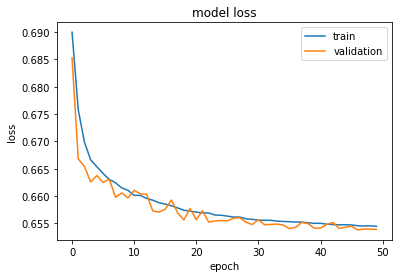

In [171]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

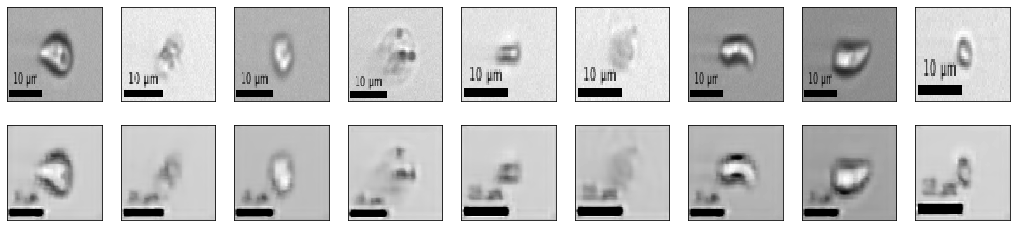

In [172]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [181]:
encoder = Model(input=input_img, output=encoded)
# model.compile(optimizer='sgd', loss='mse') # latest Keras don't need it
encoded_imgs = encoder.predict([x_test])
encoded_imgs.shape

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ma...)`



(1810, 19, 19, 8)

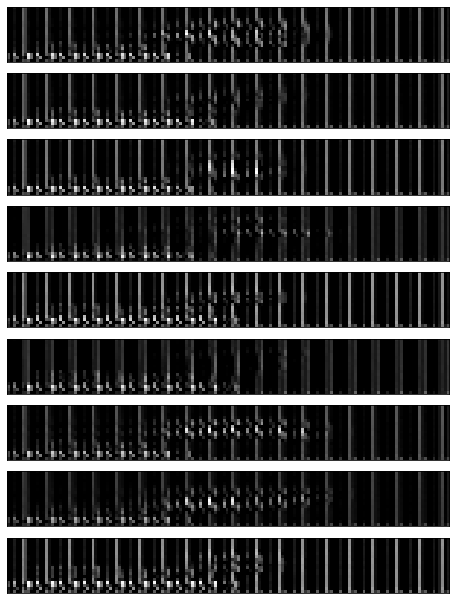

In [182]:
n = 10
plt.figure(figsize=(20, 12))
for i in range(1,n):
    ax = plt.subplot(n, 1, i)
    plt.imshow(encoded_imgs[i].reshape(19, 19 * 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

run it on the labeled data to see where it puts stuff

In [183]:
x = encoded_imgs.reshape((encoded_imgs.shape[0], -1))
x.shape

(1810, 2888)

visualize in PCA

In [184]:
X_reduced = PCA(n_components=3).fit_transform(x)
X_reduced.shape

(1810, 3)

In [185]:
y_test

array([44,  4, 35, ..., 43, 10, 43])

In [190]:
df_conv_auto_reduced = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], [id_class_dict[x] for x in  y_test]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df_conv_auto_reduced.head()

pc1         pc2          pc3           label
0  15.3460455   1.8637705   -1.4474714            t003
1   3.7510073  -3.3737218    0.5890679     Cryptophyta
2    2.703563  -1.8263415   -1.3660406  pennate 1 temp
3   5.6703396  -2.3482053  -0.64238465  centric 5 temp
4  -3.3964746  -2.3055105   0.41904783            t008

In [191]:
import plotly.express as px
fig = px.scatter_3d(df_conv_auto_reduced, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

Run this now on the validated data to see how they fall

In [198]:
from tensorflow.keras.preprocessing import image
import numpy as np

images_val = []
labels_val = []

for index, row in df_val.iterrows():
    
    # TODO need to think about optimal size and that size actually corresponds to class
    # maybe add blackspace instead of interpolating because it is changing the morphology

    img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
    images_val.append(image.img_to_array(img))
    try:
        labels_val.append(class_id_dict[row['object_annotation_category']])
    except KeyError: # this is to catch a couple nans
        print('found nan')
        labels_val.append(class_id_dict['part<other'])
images_val = np.array(images_val)
labels_val = np.array(labels_val)

images_val.shape, labels_val.shape

((22917, 150, 150, 1), (22917,))

In [202]:
images_norm_val = images_val / images_val.max()

In [203]:
images_norm_val.mean(), images_norm_val.std()

(0.46562356, 0.12173195)

In [204]:
encoded_imgs = encoder.predict([images_norm_val])

In [205]:
x = encoded_imgs.reshape((encoded_imgs.shape[0], -1))

X_reduced = PCA(n_components=3).fit_transform(x)

df_conv_auto_reduced_val = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], [id_class_dict[x] for x in labels_val]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df_conv_auto_reduced_val.head()

pc1          pc2         pc3         label
0  -1.7336113    -2.865405    2.602028   Pyramimonas
1    5.355785    -2.084283   1.6892484   Pyramimonas
2   -5.962985  -0.45186883  -1.9846083  Dictyochales
3  -1.5260022  -0.21981794  -1.0102997     Corethron
4  -6.0095596   -1.8573548  0.40912607          t011

In [206]:
fig = px.scatter_3d(df_conv_auto_reduced_val, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

Exploring the data:
* think about what classes comprise the output clusters
* what are the largest clusters?
  * how mixed are they?

In [ ]:
Look at each cluster and find the "diversity" in it

In [ ]:
Which clusters are the biggest and what is in them?

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42).fit(X)

kmeans.labels_

kmeans.predict("a bunch of other images...")

kmeans.cluster_centers_

In [ ]:
create a df with image label, validated or not, and cluster

In [ ]:
look at the clusters ranked by size and by their composition
    do this with and without val

In [ ]:
also try t-sne, and a couple other approaches...